# Homework6: VAE limitations

## Task 1: Theory (4pt)

### Problem 1: Discrete vs continuous model (2pt)
Let's suppose we have 2 generative models for images of size $W \times H \times C$, where $W$ - image width, $H$ - image height, $C$ - number of channels. 

* The first model $p_1(\mathbf{x} | \boldsymbol{\theta})$ outputs a discrete distribution for each pixel  $\text{Categorical}(\boldsymbol{\pi})$, где $\boldsymbol{\pi} = (\pi_1, \dots,  \pi_{256})$. 

* The second model $p_2(\mathbf{x} | \boldsymbol{\theta})$ models a discrete distribution by a continuous mixture of logistic functions ($\boldsymbol{\pi}$ - mixing distribution):
$$
    P(x | \boldsymbol{\mu}, \mathbf{s}, \boldsymbol{\pi}) = P(x + 0.5 | \boldsymbol{\mu}, \mathbf{s}, \boldsymbol{\pi}) - P(x - 0.5 | \boldsymbol{\mu}, \mathbf{s}, \boldsymbol{\pi}).
$$

$$
    p(\nu | \boldsymbol{\mu}, \mathbf{s}, \boldsymbol{\pi}) = \sum_{k=1}^K \pi_k p(\nu | \mu_k, s_k).
$$

Each of the models outputs parameters of pixel distributions.

* Calculate the dimensions of the output tensor for the model $p_1(\mathbf{x} | \boldsymbol{\theta})$ and for the model $p_2(\mathbf{x} | \boldsymbol{\theta})$. 
* At what number of mixture components $K$ is the number of elements of the output tensor for $p_2(\mathbf{x} | \boldsymbol{\theta})$ becomes greater than $p_1(\mathbf{x} | \boldsymbol{\theta})$.

```
your solution
```

### Problem 2: ELBO surgery (2pt)

In lecture 7 we proved the [ELBO surgery](http://approximateinference.org/accepted/HoffmanJohnson2016.pdf) theorem:
$$
    \frac{1}{n} \sum_{i=1}^n KL(q(\mathbf{z} | \mathbf{x}_i) || p(\mathbf{z})) = KL(q_{\text{agg}}(\mathbf{z}) || p(\mathbf{z})) + \mathbb{I}_{q} [\mathbf{x}, \mathbf{z}],
$$
where the first term is $KL(q_{\text{agg}}(\mathbf{z}) || p(\mathbf{z}))$ includes the aggregated posterior distribution $q_{\text{agg}}(\mathbf{z})$ and the prior distribution $p(\mathbf{z})$. Our goal now is to deal with the second term. At the lecture, the second term was equal to:

$$
    \mathbb{I}_{q} [\mathbf{x}, \mathbf{z}] = \frac{1}{n}\sum_{i=1}^n KL(q(\mathbf{z} | \mathbf{x}_i) || q_{\text{agg}}(\mathbf{z})).
$$
In fact, this is a mutual information between $\mathbf{x}$ and $\mathbf{z}$ on the empirical distribution of data and the distribution of $q(\mathbf{z} | \mathbf{x})$. Let treat the index of the sample $i$ as a random variable.
$$
    q(i, \mathbf{z}) = q(i) q(\mathbf{z} | i); \quad p(i, \mathbf{z}) = p(i) p(\mathbf{z}); \quad 
    q(i) = p(i) = \frac{1}{n}.
$$
$$
    \quad q(\mathbf{z} | i) = q(\mathbf{z} | \mathbf{x}_i) \quad q_{\text{agg}}(\mathbf{z}) = \sum_{i=1}^n q(i, \mathbf{z}) = \frac{1}{n} \sum_{i=1}^n q(\mathbf{z} | \mathbf{x}_i);  
$$
Mutual information is a measure of independence between two random variables.
$$
	\mathbb{I}_{q} [\mathbf{x}, \mathbf{z}] = \mathbb{E}_{q(i, \mathbf{z})} \log \frac{q(i, \mathbf{z})}{q(i)q_{\text{agg}}(\mathbf{z})}.
$$
Prove that 2 expressions for mutual information are equal to each other.

```your solution```

In [ ]:
REPO_NAME = "2022-2023-DGM-MIPT-course"
!if [ -d {REPO_NAME} ]; then rm -Rf {REPO_NAME}; fi
!git clone https://github.com/r-isachenko/{REPO_NAME}.git
!cd {REPO_NAME}
!pip install ./{REPO_NAME}/homeworks/
!rm -Rf {REPO_NAME}

In [62]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal
import torch.distributions as TD

USE_CUDA = torch.cuda.is_available()

In [63]:
import seaborn as sns
sns.set_theme("paper")

device = torch.device("mps")

import sys
sys.path.append('../../homeworks')

from dgm_utils import train_model, plot_training_curves
from dgm_utils import show_samples, visualize_images, load_dataset

# Task 2: VAE with Autoregressive decoder on MNIST (4pt)

In this task you will fit the VAE model with [autoregressive decoder](https://arxiv.org/abs/1611.05013) to the MNIST dataset. We discussed this topic at Lecture 4.

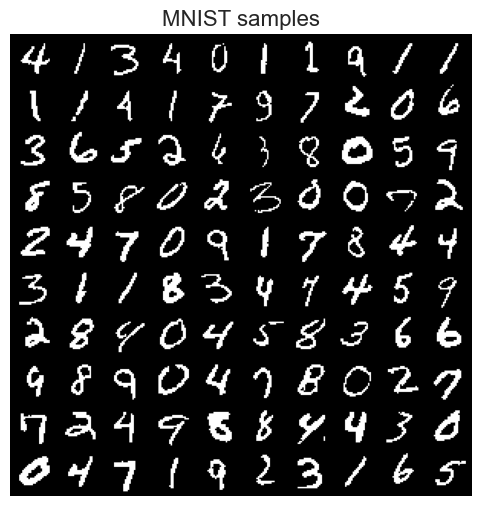

In [64]:
train_data, test_data = load_dataset('mnist', flatten=False, binarize=True)
visualize_images(train_data, 'MNIST samples')

First of all, let implement the helper functions.

In [65]:
def get_normal_KL(mean_1, log_std_1, mean_2=None, log_std_2=None):
    """
        :Parameters:
        mean_1: means of normal distributions (1)
        log_std_1 : standard deviations of normal distributions (1)
        mean_2: means of normal distributions (2)
        log_std_2 : standard deviations of normal distributions (2)
        :Outputs:
        kl divergence of the normal distributions (1) and normal distributions (2)
        ---
        This function should return the value of KL(p1 || p2),
        where p1 = Normal(mean_1, exp(log_std_1) ** 2), p2 = Normal(mean_2, exp(log_std_2) ** 2).
        If mean_2 and log_std_2 are None values, we will use standard normal distribution.
        Note that we consider the case of diagonal covariance matrix.
    """
    if mean_2 is None:
        mean_2 = torch.zeros_like(mean_1)
    if log_std_2 is None:
        log_std_2 = torch.zeros_like(log_std_1)
    assert mean_1.shape == log_std_1.shape == mean_2.shape == log_std_2.shape
    return (log_std_2 - log_std_1) + (torch.exp(log_std_1 * 2) + (mean_1 - mean_2) ** 2) / 2 / torch.exp(log_std_2 * 2) - 0.5


def test_KL():
    assert np.isclose(get_normal_KL(torch.tensor(2), torch.tensor(3), torch.tensor(0), torch.tensor(0)).numpy(), 200.2144, rtol=1e-3)
    assert np.isclose(get_normal_KL(torch.tensor(2), torch.tensor(3), torch.tensor(4), torch.tensor(5)).numpy(), 1.50925, rtol=1e-3)
    assert np.allclose(get_normal_KL(torch.tensor((10, 10)), torch.tensor((2, 4)), torch.tensor((3, 5))).numpy(), [49.2990, 1498.479], rtol=1e-3)

test_KL()

We will use PixelCNN model as the VAE decoder.

First of all we need implement masked convolution 2d layer for autoregressive decoder. It is totally the same as the layer that we used in homework 1.

However, there is a slight difference. Here, we need to model the distribution 
$$
    p(\mathbf{x} | \mathbf{z}, \boldsymbol{\theta}) = \prod_{j=1}^m p(x_j | \mathbf{x}_{1:j-1}, \mathbf{z}, \boldsymbol{\theta}).
$$
Each conditional $p(x_j | \mathbf{x}_{1:j-1}, \mathbf{z}, \boldsymbol{\theta})$ is conditioned on the latent variable $\mathbf{z}$.

To implement this conditioning we will pass $\mathbf{z}$ to our MaskedConv2d. There we will apply Linear layer to $\mathbf{z}$ and then add it to the output of masked convolution. 

In [66]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, in_channels, out_channels, kernel_size=5, padding=0, conditional_size=None):
        assert mask_type in ['A', 'B']
        super().__init__(in_channels=in_channels, out_channels=out_channels, 
                         kernel_size=kernel_size, 
                         padding=kernel_size // 2
                         #padding=padding
                        )
        self.register_buffer('mask', torch.zeros_like(self.weight))
        self.create_mask(mask_type)

        if conditional_size is not None:
            self.cond_op = nn.Linear(conditional_size, self.out_channels)
            
    def forward(self, input, cond=None):
        # ====
        # your code
        # apply masked convolution and get "out" variable
        out = F.conv2d(input,  self.mask * self.weight, padding=self.padding)
        
        #if cond not is None:
        #    out += self.cond_op(cond).reshape(out.shape)
        #super(MaskedConv2d, self).forward(input)
        # ====
        
        if cond is not None:
            cond = self.cond_op(cond)
            out = out + cond.view(cond.shape[0], self.out_channels, 1, 1)
        return out

    def create_mask(self, mask_type):
        # ====
        # your code
        # do not forget about mask_type
        m = np.zeros(self.kernel_size) 
        r = self.kernel_size[0] // 2
        for i in range(r):
            m[i, :] = 1
        m[r, :r] = 1    
        if mask_type == 'B':
            m[r, r] = 1
        self.mask = torch.tensor(m, dtype=torch.float32).expand((self.out_channels, self.in_channels, 
                                 self.kernel_size[0], self.kernel_size[1]))
        # ====


def test_masked_conv2d():
    layer = MaskedConv2d('A', 2, 2)
    assert np.allclose(layer.mask[:, :, 2, 2].numpy(), np.zeros((2, 2)))

    layer = MaskedConv2d('B', 2, 2)
    assert np.allclose(layer.mask[:, :, 2, 2].numpy(), np.ones((2, 2)))


test_masked_conv2d()

[Layer Normalization](https://arxiv.org/abs/1607.06450) helps to stabilize training process.

In [67]:
class LayerNorm(nn.LayerNorm):
    def __init__(self, n_filters):
        super().__init__(n_filters)

    def forward(self, x):
        x = x.permute(0, 2, 3, 1).contiguous()
        x = super().forward(x)
        return x.permute(0, 3, 1, 2).contiguous()

Let implement PixelCNN model.

In [68]:
class PixelCNN(nn.Module):
    def __init__(
        self, 
        input_shape, 
        n_filters=256, 
        kernel_size=3, 
        n_layers=7,
        use_layer_norm=True,
        conditional_size=None
    ):
        super().__init__()
        self.input_shape = input_shape
        
        # ====
        # your code
        # apply the sequence of MaskedConv2d -> LayerNorm -> ReLU
        # note that the first conv layer should be of type 'A'
        # the last layer should be MaskedConv2d
        # define self.net as list of layers
                
        self.net = []
        in_channels = 1
        for l in range(n_layers):
            
            mask_type = 'B'
            out_channels = n_filters
            if l == 0:
                mask_type = 'A'
            if l == n_layers - 1:
                out_channels = 2
            
            self.net.append(MaskedConv2d(mask_type, in_channels, out_channels, kernel_size=kernel_size, 
                                         conditional_size=conditional_size))
            if use_layer_norm:
                self.net.append(LayerNorm(n_filters))
            self.net.append(torch.nn.ReLU())    

            in_channels = out_channels
        self.net = torch.nn.Sequential(*self.net[:-2])
        # ====

    def forward(self, x, cond=None):
        out = (x.float() - 0.5) * 2
        for layer in self.net:
            if isinstance(layer, MaskedConv2d):
                out = layer(out, cond=cond)
            else:
                out = layer(out)
        return out.view(x.shape[0], 2, 1, *self.input_shape)

    def loss(self, x, cond=None):
        # ====
        # your code
        pass
        # ====

    def sample(self, n, cond=None):
        # read carefully the sampling process
        samples = torch.zeros(n, 1, *self.input_shape).to(device)
        with torch.no_grad():
            for r in range(self.input_shape[0]):
                for c in range(self.input_shape[1]):
                    logits = self(samples, cond=cond)[:, :, :, r, c]
                    probs = F.softmax(logits, dim=1).squeeze(-1)
                    samples[:, 0, r, c] = torch.multinomial(probs, num_samples=1).squeeze(-1)
        return samples.cpu().numpy()

We will use simple convolutional encoder here. Look carefully.

In [69]:
class ConvEncoder(nn.Module):
    def __init__(self, input_shape, latent_dim):
        super().__init__()
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        self.convs = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
        )
        conv_out_dim = input_shape[0] // 4 * input_shape[1] // 4 * 64
        self.fc = nn.Linear(conv_out_dim, 2 * latent_dim)

    def forward(self, x):
        x = (x.float() - 0.5) * 2
        out = self.convs(x)
        out = out.view(out.shape[0], -1)
        mu, log_std = self.fc(out).chunk(2, dim=1)
        return mu, log_std

Now it is time to implement the whole model.

In [70]:
m = PixelCNN(
            (28, 28), 
            n_filters=32, 
            n_layers=3,
            kernel_size=5, 
            conditional_size=16
        )
print(m)

PixelCNN(
  (net): Sequential(
    (0): MaskedConv2d(
      1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)
      (cond_op): Linear(in_features=16, out_features=32, bias=True)
    )
    (1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): MaskedConv2d(
      32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)
      (cond_op): Linear(in_features=16, out_features=32, bias=True)
    )
    (4): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (5): ReLU()
    (6): MaskedConv2d(
      32, 2, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)
      (cond_op): Linear(in_features=16, out_features=2, bias=True)
    )
  )
)


In [71]:
class ARDecoderVAE(nn.Module):
    def __init__(self, input_shape, n_latent, free_bits=None, device=device):
        super().__init__()
        assert len(input_shape) == 2

        self.input_shape = input_shape
        self.n_latent = n_latent
        self.free_bits = free_bits
        self.encoder = ConvEncoder(input_shape, n_latent)
        self.decoder = PixelCNN(
            input_shape, 
            n_filters=32, 
            n_layers=5,  
            kernel_size=7, 
            conditional_size=n_latent
        )
        
        self.device=device

    def prior(self, n):
        # ====
        # your code
        # return n samples from prior distribution (we use standart normal for prior)
        d = TD.Normal(0, 1)
        z = d.sample(torch.tensor((n, self.n_latent)))
        z = z.to(self.device) 
        return z
        # ====

    def loss(self, x):
        # ====
        # your code
        # 1) apply encoder
        # 2) apply reparametrization trick
        # 3) get decoder loss (reconstruction loss)
        # 4) get kl loss using get_normal_KL
        # 5) apply free_bits
        mu_z, log_std_z = self.encoder(x)
        eps = self.prior(x.shape[0]).to(self.device)
        z = mu_z + eps*(torch.exp(log_std_z))
        
        logits = self.decoder(x, cond=z)
        x_oh = F.one_hot(x.to(torch.int64), num_classes=2).permute(0, 4, 1, 2, 3).to(torch.float32)
        recon_loss = F.cross_entropy(logits,
                                     x_oh.to(device),
                                     reduction='sum'
                                    ) / z.shape[0]
        
        
        kl_loss = get_normal_KL(mu_z, log_std_z).sum() / z.shape[0]
        #kl_loss = (-0.5 * (1 + log_std_z - mu_z**2 - log_std_z.exp())).sum(-1).mean()
        kl_loss = kl_loss.clamp(min=self.free_bits)
        
        print(recon_loss.detach().cpu().numpy(), 
              kl_loss.detach().cpu().numpy())
        # ====

        return {
            'total_loss': recon_loss + kl_loss, 
            'recon_loss': recon_loss,
            'kl_loss': kl_loss
        }

    def sample(self, n):
        with torch.no_grad():
            z = self.prior(n).to(self.device)
            samples = self.decoder.sample(n, cond=z)
        return samples

  0%|                                                     | 0/6 [00:00<?, ?it/s]

640.63086 2.0
nan 2982905.8
2026.2625 172.85263
1867.3464 4.618888
1475.4028 4.10001
799.6549 3.0259576
543.1117 2.3829365
415.50836 2.6277049
481.36786 4.020604
491.3291 6.447653
411.52966 9.843512
514.7688 14.103676
430.59332 18.67078
441.97858 23.50152
454.49518 28.351458
408.92084 32.981937
443.61218 37.254105
384.45294 41.05666
390.76544 44.36918
394.59833 46.932373
348.5733 48.75573
343.809 49.746956
337.06525 50.285942
301.3139 50.389503
311.61606 49.910934
308.48083 48.680214
291.51422 46.83987
305.43427 44.777473
283.08743 42.77858
294.4496 40.62661
292.48132 38.115234
274.1996 35.387337
292.0822 32.780807
280.26587 30.476622
271.23413 28.332134
290.5725 26.304033
275.41364 24.429863
279.04102 22.854763
282.1169 21.520657
276.38538 20.479794
272.44562 19.729317
263.69397 19.145523
272.27765 18.740236
270.2722 18.317265
275.07138 18.002325
267.35175 17.788181
259.13113 17.68517
266.2467 17.533676
259.56 17.343155
264.40002 17.167118
254.98308 16.989614
260.14026 16.741272
254.0

68.80141 2.0
72.13156 2.0
70.39809 2.0
74.344376 2.0
74.31699 2.0
68.43602 2.0
71.56817 2.0
69.26927 2.0
72.69215 2.0
68.59075 2.0
69.838394 2.0
71.006615 2.0
69.08639 2.0
70.34406 2.0
69.012695 2.0
67.89904 2.0
72.736244 2.0
67.93913 2.0
73.261635 2.0
75.73537 2.0
71.638214 2.0
77.25485 2.0
73.926834 2.0
74.23418 2.0
72.75484 2.0
79.70997 2.0
73.43311 2.0
66.58902 2.0
68.5063 2.0
68.61583 2.0
71.315704 2.0
67.790886 2.0
71.734505 2.0
69.395515 2.0
74.85813 2.0
76.30291 2.0
73.79573 2.0
73.07405 2.0
76.88366 2.0
75.66111 2.0
75.34177 2.0
72.71184 2.0
67.239296 2.0
71.92778 2.0
75.94636 2.0
76.496666 2.0
69.66813 2.0
69.609436 2.0
72.83813 2.0
81.178894 2.0
70.176414 2.0
69.30382 2.0


 17%|███████▌                                     | 1/6 [00:57<04:47, 57.46s/it]

71.62691 2.0
72.14523 2.0
73.65994 2.0
67.25604 2.0952
72.55081 2.0
70.823105 2.0
71.04683 2.0
69.75658 2.0
67.25493 2.0
69.40468 2.0
70.1694 2.0
71.9279 2.0
71.91297 2.0
70.48386 2.0
70.85501 2.0
72.25157 2.0
71.95865 2.0454695
70.202705 2.0
70.92688 2.0
67.66403 2.0
69.3356 2.0
72.33055 2.0
72.14896 2.0
69.773254 2.0
66.345535 2.0
70.74902 2.0
70.04155 2.0
69.899506 2.0
73.27528 2.0
69.627014 2.0
67.31507 2.004745
71.082535 2.0
69.50461 2.0
70.63754 2.0
70.09921 2.0
71.60643 2.0
68.853226 2.0
72.98605 2.0
70.885056 2.0
66.37515 2.0
69.89835 2.0
68.38299 2.0
72.0159 2.0
70.787415 2.0
71.53102 2.0
68.70987 2.0
69.0255 2.1043935
68.88613 2.0
71.31597 2.0
68.911125 2.0
70.25373 2.0
67.65028 2.0
68.961365 2.0
70.57291 2.0
72.51779 2.0
70.33219 2.0
70.24151 2.0
68.74942 2.0
70.28135 2.0
70.36508 2.0
73.03917 2.0
71.94203 2.0
68.847824 2.0332854
69.42472 2.0
69.60379 2.0
73.25232 2.0
72.1725 2.0
67.248055 2.0
70.39171 2.0
69.62663 2.0
69.061 2.0
71.2814 2.0
72.13341 2.0
69.641685 2.0
70.588

 33%|███████████████                              | 2/6 [01:52<03:45, 56.30s/it]

64.49048 2.0
67.92829 2.0
78.01317 2.0
66.37369 2.0
65.153435 2.0
64.81898 2.0
67.57251 2.0
68.39924 2.0
67.586624 2.0
63.67719 2.0
67.696945 2.0
67.97047 2.0
70.34529 2.0
69.1899 2.0
67.43512 2.0
66.646324 2.0
66.70293 2.1703117
70.33185 2.0
68.81191 2.0
71.70558 2.0
67.53389 2.0
66.77787 2.0
67.64193 2.0
66.68353 2.0
68.07699 2.0
67.754814 2.0
71.94708 2.0
67.81462 2.0
66.49301 2.0
66.54865 2.0
66.15506 2.0
65.43354 2.0
66.49925 2.0
67.72281 2.0
66.62216 2.0
70.59096 2.1771874
66.45652 2.0
67.46912 2.0
64.893326 2.0
69.97771 2.0
66.38718 2.0
69.50185 2.0
68.038055 2.0
65.5684 2.0
66.391815 2.0
64.88193 2.0
67.84021 2.0
66.862854 2.0
66.06899 2.0
66.37869 2.0
69.598976 2.0
67.37894 2.0
68.97575 2.0
69.68209 2.0888355
66.943954 2.0
65.349365 2.0
67.84773 2.0
67.58003 2.0
68.92418 2.0
67.19995 2.0
68.036255 2.0
68.55693 2.0
64.93286 2.0
65.817474 2.0
68.98207 2.0
65.89993 2.0
66.706024 2.0
69.58249 2.0
72.57914 2.0
67.35731 2.088385
69.13454 2.0
68.49981 2.0
70.83381 2.0
67.57402 2.0
68

 50%|██████████████████████▌                      | 3/6 [02:48<02:48, 56.02s/it]

63.34842 2.0
67.42308 2.0
76.43685 2.0
64.54649 2.0
63.804432 2.0
63.965298 2.0
63.75489 2.0
66.426384 2.0145721
64.39807 2.0
66.46385 2.0
64.22837 2.0
66.41644 2.0
64.57544 2.0
64.7883 2.0
64.97717 2.0
69.454575 2.0
67.8925 2.0
68.6258 2.0
64.242905 2.0
69.211006 2.0
65.742615 2.0
67.40451 2.0
66.73175 2.0
64.77396 2.0
65.40998 2.0
69.39665 2.0
67.36399 2.0
64.141495 2.0545173
67.059105 2.0
64.31857 2.0
65.564026 2.0
66.39144 2.0
69.60166 2.0
67.62922 2.0
66.68111 2.0
67.08227 2.0
65.16967 2.0
64.41514 2.0
68.23381 2.0
68.69231 2.0
68.36338 2.0
66.40503 2.0
65.88069 2.0
69.87936 2.0
66.38791 2.0
66.005936 2.0875945
66.916115 2.0
67.87095 2.0
68.3461 2.0
62.283405 2.0
65.5683 2.0
72.4809 2.0
68.78537 2.0
63.15876 2.0
67.507095 2.0
66.34566 2.0
65.81903 2.0
64.52116 2.0
69.35211 2.0
66.129265 2.0
65.3492 2.0
69.588165 2.0
65.45706 2.1546688
66.70987 2.0
65.83076 2.0
69.32541 2.0
64.57536 2.0
65.05875 2.0
65.49773 2.0
64.225784 2.0
69.00901 2.0
66.162155 2.0
66.083984 2.0
67.63876 2.0
68

 67%|██████████████████████████████               | 4/6 [03:44<01:51, 55.90s/it]

62.695534 2.0
66.70136 2.0
76.293 2.0
63.879612 2.0
63.002193 2.0
63.587944 2.0
64.766235 2.0
67.90483 2.1992674
64.39876 2.0
64.82248 2.0
68.088036 2.0
64.380135 2.0
64.52638 2.0
64.22649 2.0
65.64839 2.2069435
64.33783 2.0
62.64689 2.0
64.05061 2.0
63.898457 2.0
66.94636 2.0
67.86839 2.0
62.63383 2.0
63.08327 2.0
64.9402 2.2330213
65.32418 2.0
65.79558 2.0
66.50651 2.0
64.70069 2.0
68.90784 2.0
62.78845 2.0
64.29022 2.0
65.09155 2.0
64.450386 2.0
63.499477 2.0
64.17441 2.1690302
65.91577 2.0
64.26396 2.0
63.67705 2.0
63.955498 2.0
68.124794 2.0
63.142967 2.2416866
65.42105 2.0
65.77138 2.0
66.87677 2.0
64.938065 2.0
63.951054 2.0
65.9924 2.0
64.610756 2.0
66.35447 2.0
66.40085 2.002176
66.04082 2.0
67.03096 2.0
63.39507 2.0
62.49611 2.0175748
65.28043 2.0917077
65.00794 2.0
66.255585 2.0
68.11431 2.0330677
65.55323 2.0
65.30017 2.0
66.98691 2.0
68.155075 2.0
69.55237 2.0
64.65655 2.0
67.24262 2.0
65.24678 2.4224772
65.50999 2.0
67.20242 2.0
65.71614 2.0
64.76698 2.0
61.632324 2.0
67.

 83%|█████████████████████████████████████▌       | 5/6 [04:39<00:55, 55.68s/it]

61.732613 2.0
65.865265 2.0
76.6839 2.0
63.48623 2.0
62.4516 2.0
61.883682 2.0
62.631145 2.0
64.69377 2.0
65.948814 3.23352
65.02605 2.0
63.538307 2.0
64.33493 3.8215523
64.04005 4.1030116
62.43321 4.5932784
65.08691 5.1102037
67.792465 5.159999
64.650475 4.5321856
64.34383 3.6731586
61.240456 3.0941749
62.078777 2.2579415
61.580933 2.0
62.635212 2.0
62.485054 2.0
64.41272 8.04722
62.87169 2.0
65.15442 3.5892727
65.78471 5.324254
71.15231 6.752429
69.820366 8.252465
66.43823 9.279545
65.583885 9.8043375
66.86948 10.384193
71.473335 10.802747
67.0081 10.865295
66.63638 10.624136
66.49582 10.364318
67.25638 10.101705
66.128525 9.541117
65.93123 8.866104
64.60712 8.213512
64.89369 7.451656
67.348114 6.521941
66.876335 5.511162
64.71109 4.4979477
66.68088 3.443254
65.56196 2.2818313
67.33641 2.0
65.82478 2.0
66.43989 2.0
69.83646 2.377082
63.885662 2.0
66.04324 2.0
63.614147 2.0
63.620193 2.647482
63.779526 3.1552596
64.97243 3.505921
68.68404 3.773337
63.95499 3.805881
65.268845 3.6216786

100%|█████████████████████████████████████████████| 6/6 [05:34<00:00, 55.81s/it]

61.40009 2.0
65.442635 2.0
76.12363 2.0
63.240692 2.0
62.44998 2.0
61.824768 2.0


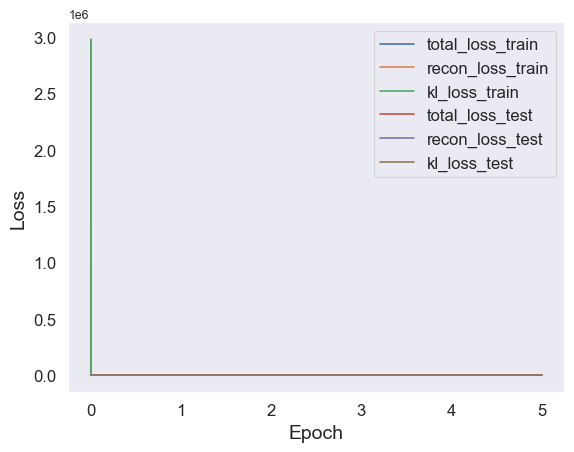

In [72]:
# ====
# your code
# choose these parameters
BATCH_SIZE = 128 # any adequate value
EPOCHS =  6    # < 10 
LR = 0.01       # < 1e-2
FREE_BITS = 2   # < 10
# ====

train_data, test_data = load_dataset('mnist', binarize=True)

#model = ARDecoderVAE(input_shape=(28, 28), free_bits=FREE_BITS, n_latent=16)
model = ARDecoderVAE(input_shape=(28, 28), free_bits=FREE_BITS, n_latent=16)
train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)

train_losses, test_losses = train_model(model, train_loader, test_loader, epochs=EPOCHS, 
                                        use_cuda=USE_CUDA, device=device, use_tqdm=True, lr=LR)

plot_training_curves(train_losses, test_losses)

Note that sampling from our model is sequential now.

total_loss: 65.9329
recon_loss: 63.9329
kl_loss: 2.0000


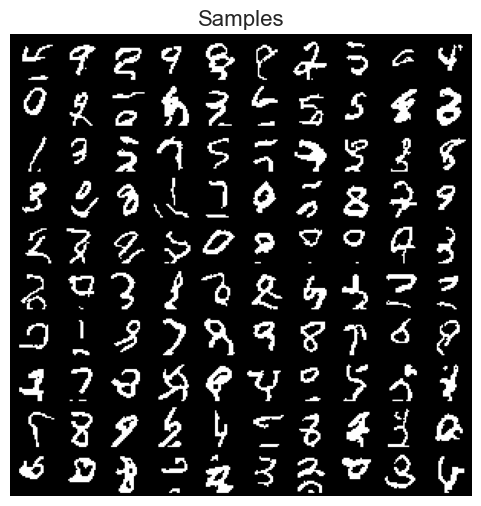

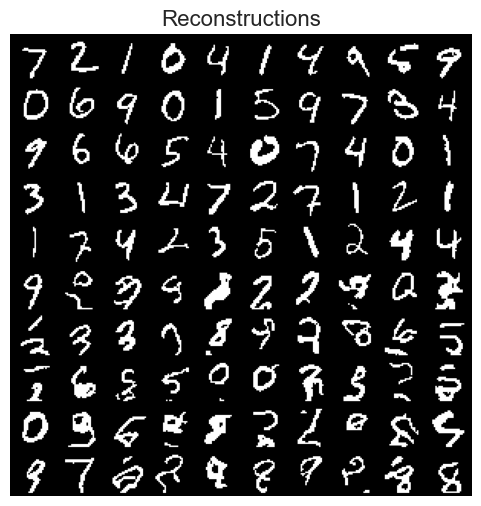

In [73]:
samples = model.sample(100)

x = next(iter(test_loader))[:50].to(device)
with torch.no_grad():
    z, _ = model.encoder(2 * x - 1)
    x_recon = model.decoder.sample(50, cond=z)
x = x.cpu().numpy()
reconstructions = np.concatenate((x, x_recon), axis=0)

samples = samples.astype('float32')
reconstructions = reconstructions.astype('float32')

for key, value in test_losses.items():
    print('{}: {:.4f}'.format(key, value[-1]))
show_samples(samples, title='Samples')
show_samples(reconstructions, title='Reconstructions')

total_loss: 2.1688
recon_loss: 0.0834
kl_loss: 2.0854


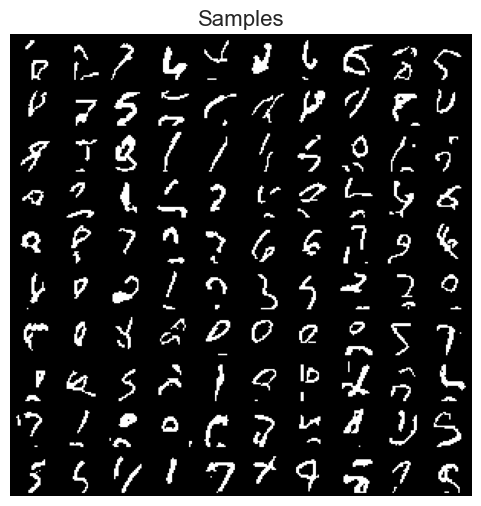

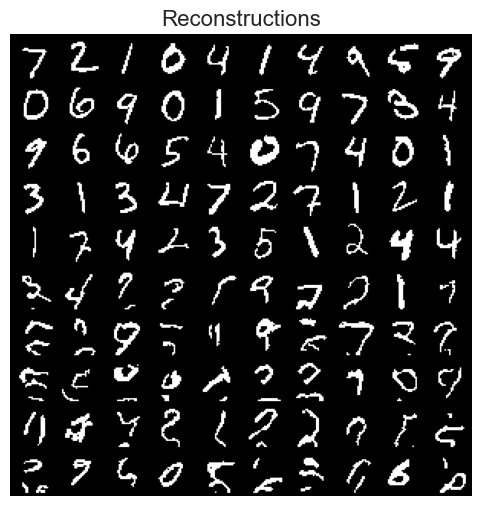

In [253]:
samples = model.sample(100)

x = next(iter(test_loader))[:50].to(device)
with torch.no_grad():
    z, _ = model.encoder(2 * x - 1)
    x_recon = model.decoder.sample(50, cond=z)
x = x.cpu().numpy()
reconstructions = np.concatenate((x, x_recon), axis=0)

samples = samples.astype('float32')
reconstructions = reconstructions.astype('float32')

for key, value in test_losses.items():
    print('{}: {:.4f}'.format(key, value[-1]))
show_samples(samples, title='Samples')
show_samples(reconstructions, title='Reconstructions')

# Task 3: VAE with Autoregressive flow-based prior on CIFAR10 (5pt)

In this task you will fit the VAE model with [flow-based prior](https://arxiv.org/abs/1611.02731) to the CIFAR10 dataset. We discussed this topic at Lecture 7.

Files already downloaded and verified
Files already downloaded and verified


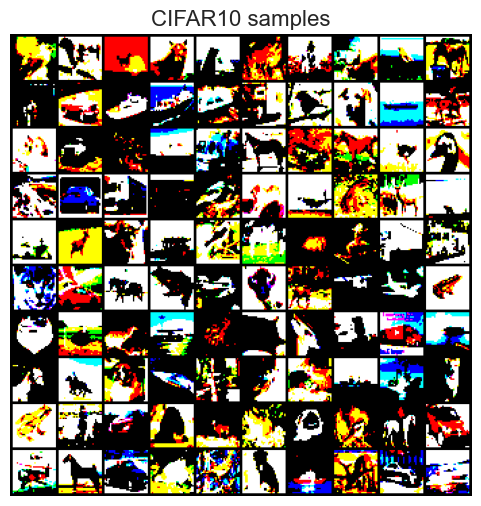

In [3]:
train_data, test_data = load_dataset('cifar10')
visualize_images(train_data, 'CIFAR10 samples')

The model consists of:
* convolutional encoder (variational posterior destrituion $q(\mathbf{z} | \mathbf{x})$);
* convolutional decoder (generative distribution $p(\mathbf{x} | \mathbf{z})$);
* autoregressive prior.

We will use MADE model as autoregressive prior. MADE Autoregressive frow (mapping from $\mathbf{z}\rightarrow \boldsymbol{\epsilon}$) should output location $\mu_{\boldsymbol{\lambda}}(\mathbf{z})$ and scale parameters $\sigma_\boldsymbol{\lambda}(\mathbf{z})$. The mapping from $\mathbf{z}$ to $\boldsymbol{\epsilon}$ has the form:
$$
    \boldsymbol{\epsilon} = f(\mathbf{z}, \boldsymbol{\lambda}) = \mathbf{z} * \sigma_\boldsymbol{\lambda}(\mathbf{z}) + \mu_{\boldsymbol{\lambda}}(\mathbf{z}).
$$

The ELBO objective in this task is:
$$
    \mathcal{L}(\boldsymbol{\phi}, \boldsymbol{\theta}, \boldsymbol{\lambda}) = E_{q(\mathbf{z}|\mathbf{x}, \boldsymbol{\phi})}[\log{p(\mathbf{x}|\mathbf{z}, \boldsymbol{\theta})}] - E_{q(\mathbf{z}|\mathbf{x}, \boldsymbol{\phi})}[\log{q(\mathbf{z}|\mathbf{x}, \boldsymbol{\phi})} - \log{p(\mathbf{z} | \boldsymbol{\lambda})}]
$$
where the logarithm of prior distribution is given by chage of variable (CoV) theorem
$$
    \log{p(\mathbf{z} | \boldsymbol{\lambda})} = \log{p(\boldsymbol{\epsilon})} + \log{\left|\det\left(\frac{d\boldsymbol{\epsilon}}{d\mathbf{z}}\right)\right|} = \log{p(f(\mathbf{z}, \boldsymbol{\lambda}))} + \log{\left|\det\left(\frac{\partial f(\mathbf{z}, \boldsymbol{\lambda})}{\partial \mathbf{z}}\right)\right|}.
$$

Here we define convolutional encoder and decoder. You could use this architecture or experiment with it.

In [5]:
class ConvEncoder(nn.Module):
    def __init__(self, input_shape, n_latent):
        super().__init__()
        self.input_shape = input_shape
        self.n_latent = n_latent
        self.convs = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
        )
        conv_out_dim = input_shape[1] // 8 * input_shape[2] // 8 * 256
        self.fc = nn.Linear(conv_out_dim, 2 * n_latent)

    def forward(self, x):
        out = self.convs(x)
        out = out.view(out.shape[0], -1)
        mu, log_std = self.fc(out).chunk(2, dim=1)
        return mu, log_std
        

class ConvDecoder(nn.Module):
    def __init__(self, n_latent, output_shape):
        super().__init__()
        self.n_latent = n_latent
        self.output_shape = output_shape

        self.base_size = (128, output_shape[1] // 8, output_shape[2] // 8)
        self.fc = nn.Linear(n_latent, np.prod(self.base_size))
        self.deconvs = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, output_shape[0], 3, padding=1),
        )

    def forward(self, z):
        out = self.fc(z)
        out = out.view(out.shape[0], *self.base_size)
        return self.deconvs(out)

For autoregressive prior we will use MADE model. Do not change these classes, but read it carefully.

In [28]:
class MaskedLinear(nn.Linear):
    # do not change this class
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)
        self.register_buffer('mask', torch.ones(out_features, in_features))

    def set_mask(self, mask):
        self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))

    def forward(self, input):
        return F.linear(input, self.mask * self.weight, self.bias)


class MADE(nn.Module):
    # do not change this class
    def __init__(self, input_shape, d, hidden_size=[512, 512]):
        super().__init__()
        self.input_shape = input_shape
        self.nin = np.prod(input_shape)
        self.nout = self.nin * d
        self.d = d
        self.hidden_sizes = hidden_size
        self.ordering = np.arange(self.nin)

        self.net = []
        hs = [self.nin] + self.hidden_sizes + [self.nout]
        for h0, h1 in zip(hs, hs[1:]):
            self.net.extend([
                MaskedLinear(h0, h1),
                nn.ReLU(),
            ])
        self.net.pop()
        self.net = nn.ModuleList(self.net)

        self.m = {}
        self.create_mask()

    def create_mask(self):
        L = len(self.hidden_sizes)

        self.m[-1] = self.ordering
        for l in range(L):
            self.m[l] = np.random.randint(self.m[l - 1].min(),
                                          self.nin - 1, size=self.hidden_sizes[l])

        masks = [self.m[l - 1][:, None] <= self.m[l][None, :] for l in range(L)]
        masks.append(self.m[L - 1][:, None] < self.m[-1][None, :])

        masks[-1] = np.repeat(masks[-1], self.d, axis=1)

        layers = [l for l in self.net.modules() if isinstance(l, MaskedLinear)]
        for l, m in zip(layers, masks):
            l.set_mask(m)

    def forward(self, x):
        batch_size = x.shape[0]
        out = x.view(batch_size, self.nin)
        for layer in self.net:
            out = layer(out)
        out = out.view(batch_size, self.nin, self.d)
        return out

Let implement VAE with autoregressive prior model.

In [29]:
def get_normal_nll(x, mean, log_std):
    """
        This function should return the negative log likelihood log p(x),
        where p(x) = Normal(x | mean, exp(log_std) ** 2).
        Note that we consider the case of diagonal covariance matrix.
    """
    return 0.5 * np.log(2 * np.pi) + log_std + (x - mean) ** 2 * torch.exp(-2 * log_std) * 0.5

def get_normal_KL(mean_1, log_std_1, mean_2=None, log_std_2=None):
    """
        :Parameters:
        mean_1: means of normal distributions (1)
        log_std_1 : standard deviations of normal distributions (1)
        mean_2: means of normal distributions (2)
        log_std_2 : standard deviations of normal distributions (2)
        :Outputs:
        kl divergence of the normal distributions (1) and normal distributions (2)
        ---
        This function should return the value of KL(p1 || p2),
        where p1 = Normal(mean_1, exp(log_std_1) ** 2), p2 = Normal(mean_2, exp(log_std_2) ** 2).
        If mean_2 and log_std_2 are None values, we will use standard normal distribution.
        Note that we consider the case of diagonal covariance matrix.
    """
    if mean_2 is None:
        mean_2 = torch.zeros_like(mean_1)
    if log_std_2 is None:
        log_std_2 = torch.zeros_like(log_std_1)
    assert mean_1.shape == log_std_1.shape == mean_2.shape == log_std_2.shape
    return (log_std_2 - log_std_1) + (torch.exp(log_std_1 * 2) + (mean_1 - mean_2) ** 2) / 2 / torch.exp(log_std_2 * 2) - 0.5

In [30]:
m = MADE((1, 16), 2)
print(m)

MADE(
  (net): ModuleList(
    (0): MaskedLinear(in_features=16, out_features=512, bias=True)
    (1): ReLU()
    (2): MaskedLinear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): MaskedLinear(in_features=512, out_features=32, bias=True)
  )
)


In [58]:
class ARFPriorVAE(nn.Module):
    def __init__(self, input_shape, n_latent, device=device):
        super().__init__()
        assert len(input_shape) == 3
        self.input_shape = input_shape
        self.n_latent = n_latent
        self.device = device

        # ====
        # your code
        # define made model, encoder and decoder
        self.encoder = ConvEncoder(input_shape, n_latent)
        self.decoder = ConvDecoder(n_latent, output_shape=input_shape)
        self.made = MADE(n_latent, 2)
        
        self.prior_distr = TD.Normal(0, 1)
        # ====

    def prior_z(self, n):
        return torch.randn(n, self.n_latent).to(next(self.parameters()))
        
    def loss(self, x):
        x = 2 * x.float() - 1

        # ====
        # your code
        # 1) apply encoder to x to get variational posterior distribution parameters
        # 2) sample z from variational posterior distribution (reparametrization trick)
        # 3) apply decoder to get reconstruction
        mu_z, log_std_z = self.encoder(x)
        
        eps = self.prior_distr.sample(log_std_z.shape).to(self.device)
        #eps = self.prior_z(mu_z.shape[0])
        z = eps * torch.exp(log_std_z) + mu_z
        
        mu_x = self.decoder(z)
        log_std_x = torch.zeros_like(mu_x)
        # ====

        # ====
        # your code
        # 1) compute reconstruction loss (first term in ELBO) 
        # in this case we could use mse loss 
        # (we will get beta-VAE model since the contributions of reconstruction loss and KL term become dishonest) 
        # 2) compute encoder log prob (it is a log of normal distribution on z)
        # 3) apply MADE model to z to get mu and log_std
        
        recon_loss = F.mse_loss(mu_x, x, reduction='sum') / x.shape[0]   # !!!!!!
        #print(x.shape, mu_x.shape, log_std_x.shape)
        #recon_loss = get_normal_nll(x, mu_x, log_std_x).sum(1).mean()
        
        d_normal = TD.Normal(mu_z, torch.exp(log_std_z))
        posterior_log_prob = d_normal.log_prob(z).sum()
    
        
        mu, log_std = self.made(z).chunk(2, dim=-1)
        mu, log_std = mu.squeeze(-1), log_std.squeeze(-1)
        # ====

        # this trick is just for model stability (do not touch it)
        log_std = torch.tanh(log_std)

        # ====
        # your code
        # 1) scale z to sigma and shift to mu get epsilon
        # 2) compute prior log prob (log of standart normal)
        # 3) kl loss is difference between encoder log prob and prior log prob
                
        eps = z * torch.exp(log_std) + mu
        prior_log_prob = self.prior_distr.log_prob(eps) + log_std
        prior_log_prob = prior_log_prob.sum()
        kl_loss = (posterior_log_prob - prior_log_prob) / x.shape[0]    # !!!!!!
        
        #print(recon_loss.detach().cpu().numpy(), kl_loss.detach().cpu().numpy())
        
        # ====
        return {
            'total_loss': recon_loss + kl_loss,
            'recon_loss': recon_loss,
            'kl_loss': kl_loss
        }
    
    def prior(self, n):
        # ====
        # your code
        # return n samples from prior distribution (we use standard normal for prior)
        
        z = self.prior_distr.sample(torch.tensor((n, self.n_latent)))
        z = z.to(self.device)
        return z

    def sample(self, n):
        with torch.no_grad():
            z = self.prior(n).to(self.device)
            # investigate how to sample from autoregressive model (do not change this part)
            for i in range(self.n_latent):
                mu, log_std = self.made(z)[:, i].chunk(2, dim=-1)
                log_std = torch.tanh(log_std)
                mu, log_std = mu.squeeze(-1), log_std.squeeze(-1)
                z[:, i] = (z[:, i] - mu) * torch.exp(-log_std)
            return self.decoder(z).cpu().numpy() * 0.5 + 0.5

In [59]:
# ====
# your code
# choose these parameters
BATCH_SIZE = 128  # any adequate value
EPOCHS =  20    # < 20
LR = 0.001        # < 1e-3
# ====

model = ARFPriorVAE((3, 32, 32), 16)

100%|███████████████████████████████████████████| 20/20 [05:43<00:00, 17.20s/it]


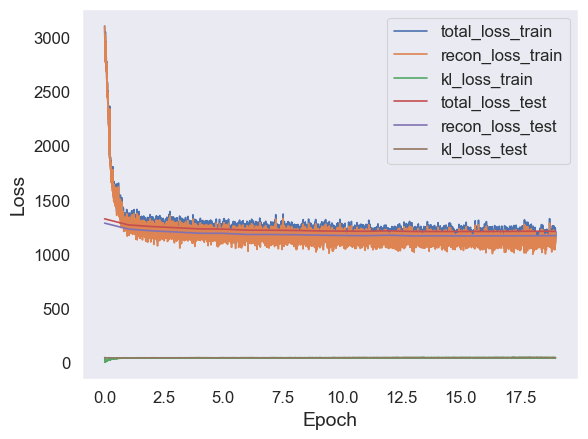

In [60]:
train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)
train_losses, test_losses = train_model(model, train_loader, test_loader, use_cuda=USE_CUDA, 
                                        device=device, epochs=EPOCHS, use_tqdm=True, lr=LR)

plot_training_curves(train_losses, test_losses)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


total_loss: 1209.4662
recon_loss: 1169.1340
kl_loss: 40.3322


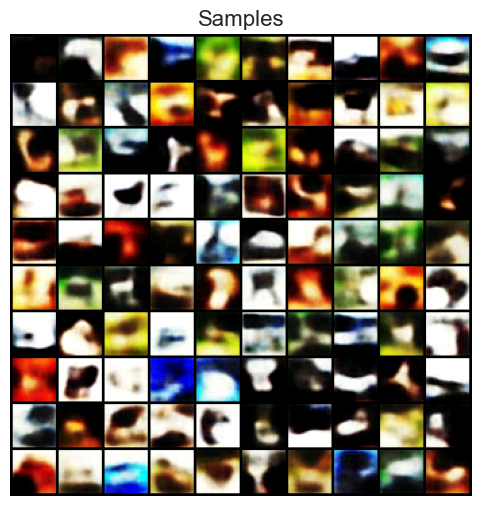

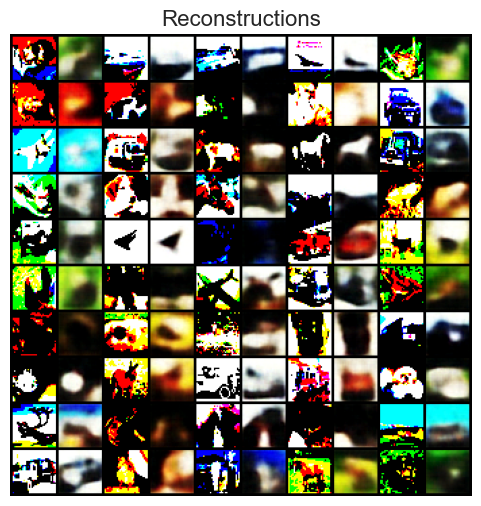

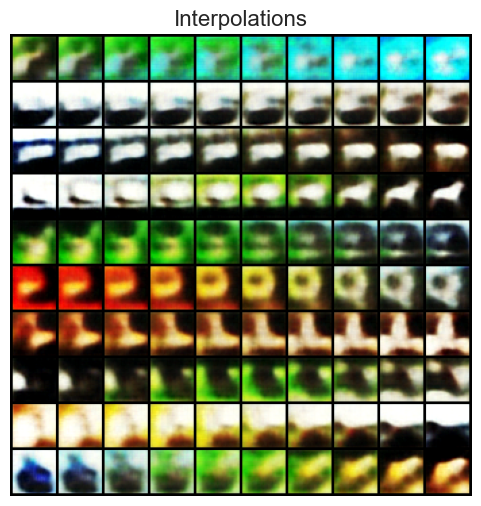

In [61]:
samples = model.sample(100)

x = next(iter(test_loader))[:50]
x = x.to(device)

with torch.no_grad():
    z = model.encoder(2 * x - 1)[0]
    x_recon = torch.clamp(model.decoder(z) * 0.5 + 0.5, 0, 1)

reconstructions = torch.stack((x, x_recon), dim=1).view(-1, 3, 32, 32)
reconstructions = reconstructions.cpu()

x = next(iter(test_loader))[:20]
x = x.to(device)

with torch.no_grad():
    x = 2 * x - 1
    z, _ = model.encoder(x)
    z1, z2 = z.chunk(2, dim=0)
    interps = [model.decoder(z1 * (1 - alpha) + z2 * alpha) for alpha in torch.linspace(0, 1, 10)]
    interps = torch.stack(interps, dim=1).view(-1, 3, 32, 32)
    interps = torch.clamp(interps * 0.5 + 0.5, 0, 1)
interps = interps.cpu()

for key, value in test_losses.items():
    print('{}: {:.4f}'.format(key, value[-1]))
    
show_samples(samples, title='Samples')
show_samples(reconstructions, title='Reconstructions')
show_samples(interps, title='Interpolations')

**Note:** we do not use complicated architectures for encoder and decoder in this task. That is why your samples could be blurry, it is ok. The main goal of this task is to understand the theory around flow-based prior. But of course you could experiment with more complex networks (like ResNet) for additional points.